In [16]:
import pandas as pd
import numpy as np
import os

### Receptive Fields

In [60]:
class NeuropixelsFeatureExtractor:
    def __init__(self, path='data'):
        self.path = path
        self.billeh_to_neuropixels_area_mapping = {'v1': 'VISp', 'lm': 'VISl'}

    def process_neuropixels_data(self, area='v1'):
        ### Load the data ###
        unit_table_path = f"unit_table.csv"
        if unit_table_path not in os.listdir("data"):
            with open('create_units_table.py') as file:
                exec(file.read())

        df_all = pd.read_csv(os.path.join(self.path, unit_table_path))
        billeh_to_neuropixels_area_mapping = {'v1':'VISp', 'lm':'VISl'}
        # Exc and PV have sufficient number of cells, so we'll filter out non-V1 Exc and PV.
        # SST and VIP are small populations, so let's keep also non-V1 neurons
        exclude = (df_all["cell_type"].isnull() | df_all["cell_type"].str.contains("EXC") | df_all["cell_type"].str.contains("PV")) \
                & (df_all["ecephys_structure_acronym"] != billeh_to_neuropixels_area_mapping[area])
        df = df_all[~exclude]
        print(f"Original: {df_all.shape[0]} cells,   filtered: {df.shape[0]} cells")

        # Some cells have very large values of RF. They are likely not-good fits, so ignore.
        df.loc[(df["width_rf"] > 100), "width_rf"] = np.nan
        df.loc[(df["height_rf"] > 100), "height_rf"] = np.nan

        # Save the processed table
        df_path = os.path.join(self.path, f'{area}_experimental_features_df.csv')
        df.to_csv(df_path, sep=" ", index=False)
        # return df

    @staticmethod
    def neuropixels_cell_type_to_cell_type(pop_name):
        # Convert pop_name in the neuropixels cell type to cell types. E.g, 'EXC_L23' -> 'L2/3 Exc', 'PV_L5' -> 'L5 PV'
        layer = pop_name.split('_')[1]
        class_name = pop_name.split('_')[0]
        if "2" in layer:
            layer = "L2/3"
        elif layer == "L1":
            return "L1 Htr3a"  # special case
        if class_name == "EXC":
            class_name = "Exc"
        if class_name == 'VIP':
            class_name = 'Htr3a'

        return f"{layer} {class_name}"

    def get_feature_df(self, area='v1', features=['area_rf']):
        # Load data
        neuropixels_data_path = os.path.join(self.path, f'{area}_experimental_features_df.csv')
        if not os.path.exists(neuropixels_data_path):
            self.process_neuropixels_data(area=area)

        features_to_load = ['ecephys_unit_id','cell_type'] + features
        receptive_field_df = pd.read_csv(neuropixels_data_path, index_col=0, sep=" ", usecols=features_to_load).dropna(how='all')
        receptive_field_df.dropna(inplace=True)
        receptive_field_df.loc[:, "cell_type"] = receptive_field_df.loc[:, "cell_type"].apply(self.neuropixels_cell_type_to_cell_type)

        return receptive_field_df

In [61]:
# call the class and get receptive fields
features = ['area_rf', 'time_to_first_spike_fl']
DataExtractor = NeuropixelsFeatureExtractor(path='data')
v1_df = DataExtractor.get_feature_df(features=features, area='v1')
v1_df

,area_rf,cell_type,time_to_first_spike_fl
ecephys_unit_id,,,
950907975,1500.0,L1 Htr3a,0.142
950908404,800.0,L6 Exc,0.157
950908410,400.0,L6 PV,0.053
950908414,100.0,L6 Exc,0.181
950908416,400.0,L6 Exc,0.140
...,...,...,...
951910862,1200.0,L2/3 Exc,0.122
951910868,1100.0,L2/3 Exc,0.045
951910924,800.0,L2/3 PV,0.132


In [63]:
lm_df = DataExtractor.get_feature_df(features=features, area='lm')
lm_df

,area_rf,cell_type,time_to_first_spike_fl
ecephys_unit_id,,,
950907975,1500.0,L1 Htr3a,0.142
950909307,200.0,L6 Exc,0.166
950909331,0.0,L5 Exc,0.073
950909343,600.0,L5 PV,0.082
950909345,400.0,L5 Exc,0.102
...,...,...,...
951883815,700.0,L1 Htr3a,0.062
951909078,700.0,L4 SST,0.071
951909219,800.0,L1 Htr3a,0.154


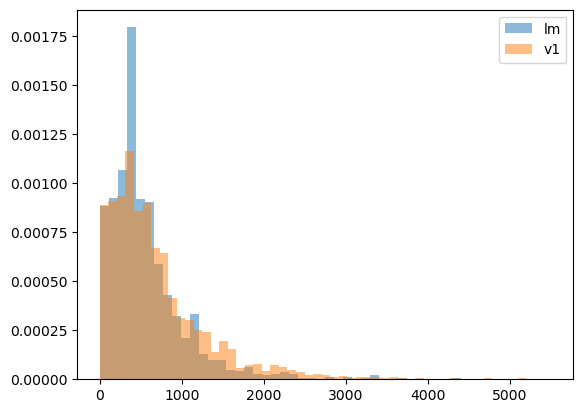

In [55]:
# plot a histogram with both tfs_df['time_to_first_spike_fl'] and tfs_df2['time_to_first_spike_fl']
import matplotlib.pyplot as plt
feature = 'area_rf'
plt.hist(v1_df[feature], bins=50, density=True, alpha=0.5, label='lm')
plt.hist(lm_df[feature], bins=50, density=True, alpha=0.5, label='v1')
plt.legend(loc='upper right')
plt.show()

## Time to first spike

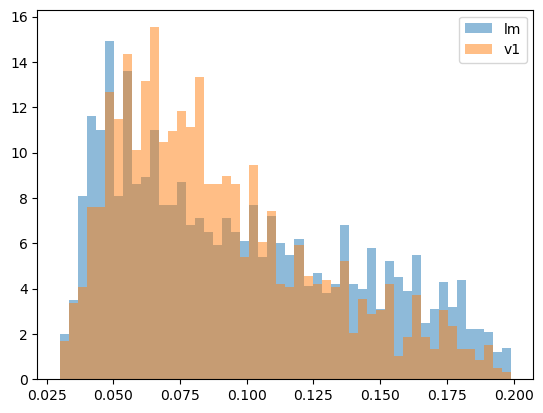

In [64]:
# plot a histogram with both tfs_df['time_to_first_spike_fl'] and tfs_df2['time_to_first_spike_fl']
# plot a histogram with both tfs_df['time_to_first_spike_fl'] and tfs_df2['time_to_first_spike_fl']
import matplotlib.pyplot as plt
feature = 'time_to_first_spike_fl'
plt.hist(v1_df[feature], bins=50, density=True, alpha=0.5, label='lm')
plt.hist(lm_df[feature], bins=50, density=True, alpha=0.5, label='v1')
plt.legend(loc='upper right')
plt.show()